In [5]:
from jax import config
config.update("jax_enable_x64", True)

In [6]:
from PIL import Image
from scipy.io import loadmat
import subprocess

from scipy.optimize import minimize
from tqdm.autonotebook import tqdm
from matplotlib.patches import Patch


/tmp/ipykernel_1169670/3355760260.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
from ndgsp.algorithms import *
from ndgsp.graphs import ProductGraph
from ndgsp.filters import UnivariateFilterFunction
from ndgsp.models import LRNC, LGSR, MulticlassLGSR, MulticlassLRNC
from ndgsp.utils.arrays import one_hot


Using Jax backend with device gpu:0


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

pd.set_option('display.max_rows', 60)
pd.set_option('display.min_rows', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 40)

%load_ext autoreload
%autoreload 2

%matplotlib ipympl



In [5]:
im1 = Image.open('data/12003.jpg')
gt1 = loadmat('data/12003.mat')['groundTruth'][0][0][0][0][0] == 2

im2 = Image.open('data/41004.jpg')
gt2 = loadmat('data/41004.mat')['groundTruth'][0][0][0][0][0] == 2

im3 = Image.open('data/108073.jpg')
gt3 = loadmat('data/108073.mat')['groundTruth'][0][0][0][0][0] == 3

im4 = Image.open('data/113016.jpg')
gt4 = (loadmat('data/113016.mat')['groundTruth'][0][0][0][0][0] == 2) | (loadmat('data/113016.mat')['groundTruth'][0][0][0][0][0] == 3)

In [7]:
ims = [im1, im2, im3, im4]
gts = [gt1, gt2, gt3, gt4]

In [57]:
def get_data_uniform(im, gt, s, seed):

    np.random.seed(seed)

    all_inds = np.indices(im.size).reshape(2, -1).T

    np.random.shuffle(all_inds)

    Y = gt.copy().astype(float)
    X = np.array(im)
    S = np.zeros_like(Y)
    
    N = np.prod(Y.shape)
    N_ = int((1 - s) * N)
    Y[all_inds[:N_, 1], all_inds[:N_, 0]] = np.nan

    return X.astype(float), Y, gt



In [9]:
def get_best_lrnc(i, m, seed):

    im = ims[i]
    gt = gts[i]

    X, Y, gt = get_data_uniform(im, gt, m, seed)

    graph = ProductGraph.lattice(im.size[1], im.size[0])
    fil = UnivariateFilterFunction.diffusion(20)

    mod = LRNC(X, Y, graph, fil, gamma=1, lam=10)


    def loss(mu_pred):

        return -(gt * np.log(mu_pred) + (1 - gt) * np.log(1 - mu_pred)).sum()
    
    def get_los(params):

        gamma, beta, lam = np.exp(params) 

        mod.set_gamma(gamma)
        mod.set_beta(beta)
        mod.set_lam(lam)

        mu = mod.solve(classify=False)

        l =  loss(mu)

        print(f'params: [{gamma:.4e}, {beta:.4e}, {lam:.4e}], Loss: {l:.4f}', end='\r')

        return l 
    
    return minimize(get_los, x0=[1, 1, 1], method='Nelder-Mead', options={'maxiter': 20})


def get_best_lgsr(i, m, seed):

    im = ims[i]
    gt = gts[i]

    X, Y, gt = get_data_uniform(im, gt, m, seed)

    graph = ProductGraph.lattice(im.size[1], im.size[0])
    fil = UnivariateFilterFunction.diffusion(20)

    mod = LGSR(Y, graph, fil, gamma=1)


    def loss(mu_pred):

        return -(gt * np.log(mu_pred) + (1 - gt) * np.log(1 - mu_pred)).sum()
    
    def get_los(params):

        gamma, beta = np.exp(params) 

        mod.set_gamma(gamma)
        mod.set_beta(beta)

        mu = mod.solve(classify=False)

        l =  loss(mu)

        print(f'params: [{gamma:.4e}, {beta:.4e}], Loss: {l:.4f}', end='\r')

        return l 
    
    return minimize(get_los, x0=[1, 1], method='Nelder-Mead', options={'maxiter': 20})



In [10]:
def plot_basic():

    lgsrs = []
    lrncs = []

    for i, (im, gt) in enumerate(zip(ims, gts)):

        graph = ProductGraph.lattice(im.size[1], im.size[0])
        fil = UnivariateFilterFunction.diffusion(20)

        X, Y, gt = get_data_uniform(im, gt, 0.1, seed=0)

        lrnc = LRNC(X, Y, graph, fil, gamma=5e-5, lam=1e4)
        lgsr = LGSR(Y, graph, fil, gamma=5e-5)

        lgsrs.append(lgsr.solve(classify=False))
        lrncs.append(lrnc.solve(classify=False))


    fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(8, 6), sharex='row', sharey='row')

    for i, (im, gt) in enumerate(zip(ims, gts)):

        axes[i, 0].imshow(im)
        axes[i, 1].imshow(gt, interpolation='nearest')

        axes[i, 2].imshow(lgsrs[i])
        axes[i, 3].imshow(lrncs[i])


        for ax in axes[i]:
            ax.axis('off')

    plt.tight_layout()

    # plt.savefig('segmentation.pdf')

    # subprocess.run(['pdfcrop', 'segmentation.pdf', 'segmentation.pdf'])

In [11]:
import time

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `fraction_labelled.pdf'.


CompletedProcess(args=['pdfcrop', 'fraction_labelled.pdf', 'fraction_labelled.pdf'], returncode=0)

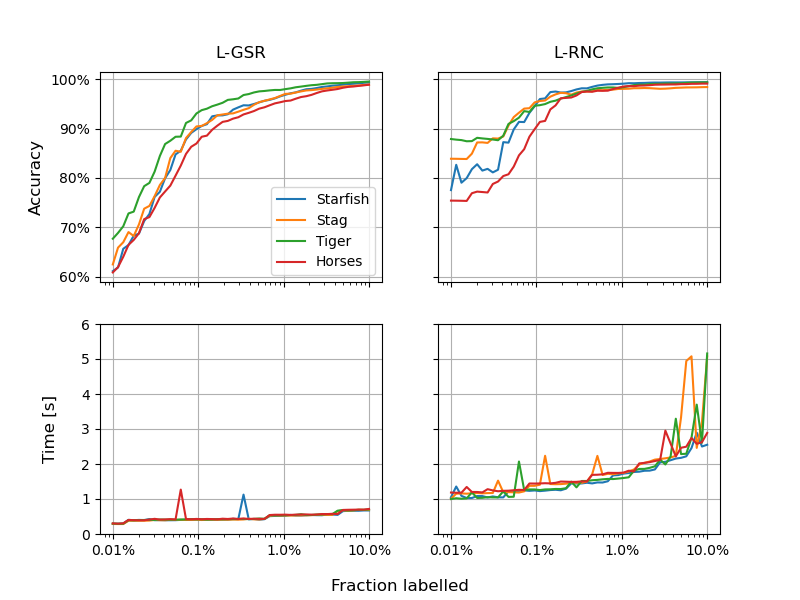

In [50]:
def plot_accuracy():

    def accuracy(pred, gt):
        return (pred == gt).sum() / np.prod(gt.shape)

    graph = ProductGraph.lattice(im1.size[1], im1.size[0])

    lgsrs = []
    lrncs = []

    lgsrts = []
    lrncts = []

    fil1 = UnivariateFilterFunction.diffusion(100)
    fil2 = UnivariateFilterFunction.diffusion(5)

    frac = np.logspace(-4, -1, 50)

    for im, gt in zip(ims, gts):

        lgsrs.append([])
        lrncs.append([])

        lgsrts.append([])
        lrncts.append([])

        for m in tqdm(frac):

            X, Y, gt = get_data_uniform(im, gt, m, seed=2)

            lrnc = LRNC(X, Y, graph, fil1, gamma=5e-5, lam=1e4)
            lgsr = LGSR(Y, graph, fil2, gamma=5e-3)

            t0 = time.time()
            lgsrs[-1].append(accuracy(lgsr.solve(classify=True), gt))
            t1 = time.time()
            lrncs[-1].append(accuracy(lrnc.solve(classify=True), gt))
            t2 = time.time()

            lgsrts[-1].append(t1 - t0)
            lrncts[-1].append(t2 - t1)


    fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey='row', figsize=(8, 6))

    for i, label in enumerate(['Starfish', 'Stag', 'Tiger', 'Horses']):

        axes[0, 0].plot(frac, lgsrs[i], label=label)
        axes[0, 1].plot(frac, lrncs[i])
        axes[1, 0].plot(frac, lgsrts[i])
        axes[1, 1].plot(frac, lrncts[i])


    axes[0, 0].legend()

    pc_fmt = lambda x, pos: '{}%'.format(100 * x)

    for ax in axes.flatten():

        ax.set_xscale('log')
        ax.grid()

        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(pc_fmt))

    axes[1, 0].set_ylim(0, 6)
    axes[1, 0].set_ylabel('Time [s]', labelpad=17, fontsize='large')

    fmt = lambda x, pos: '{:.0f}%'.format(100 * x)

    axes[0, 0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
    axes[0, 0].set_ylabel('Accuracy', labelpad=5, fontsize='large')

    fig.supxlabel('Fraction labelled')

    axes[0, 0].set_title('L-GSR', pad=10)
    axes[0, 1].set_title('L-RNC', pad=10)

    plt.savefig('fraction_labelled.pdf')

    subprocess.run(['pdfcrop', 'fraction_labelled.pdf', 'fraction_labelled.pdf'])

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `starfish.pdf'.


CompletedProcess(args=['pdfcrop', 'starfish.pdf', 'starfish.pdf'], returncode=0)

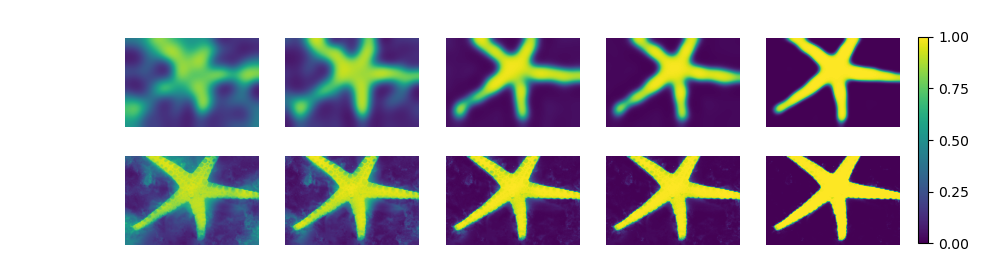

In [140]:
def plot_starfish():
    
    lgsrs = []
    lrncs = []

    graph = ProductGraph.lattice(im1.size[1], im1.size[0])
    fil = UnivariateFilterFunction.diffusion(100)

    for m in [5e-4, 1e-3, 5e-3, 1e-2, 1e-1]:

        X, Y, gt = get_data_uniform(im1, gt1, m, seed=0)

        lrnc = LRNC(X, Y, graph, fil, gamma=5e-5, lam=1e4)
        lgsr = LGSR(Y, graph, fil, gamma=5e-5)

        lgsrs.append(lgsr.solve())
        lrncs.append(lrnc.solve())


    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 2.8))


    for i in range(5):

        cb = axes[0, i].imshow(lgsrs[i], vmin=0, vmax=1)
        axes[1, i].imshow(lrncs[i], vmin=0, vmax=1)

    for ax in axes.ravel():
        ax.axis('off')

    ax = fig.add_axes([0.68, 0.1, 0.28, 0.8])
    ax.axis('off')
    plt.colorbar(cb, ax=ax,  ticks=[0, 0.25, 0.5, 0.75, 1], location='right', shrink=0.92)

    plt.savefig('starfish.pdf')

    subprocess.run(['pdfcrop', 'starfish.pdf', 'starfish.pdf'])

In [61]:
def plot_starfish2():
    
    lgsrs = []
    lrncs = []

    graph = ProductGraph.lattice(im1.size[1], im1.size[0])
    fil = UnivariateFilterFunction.diffusion(100)

    for beta in [10, 50, 100, 200, 500]:

        fil.set_beta(beta)

        X, Y, gt = get_data_uniform(im1, gt1, 5e-4, seed=0)

        lrnc = LRNC(X, Y, graph, fil, gamma=5e-5, lam=1e4)
        lgsr = LGSR(Y, graph, fil, gamma=5e-5)

        lgsrs.append(lgsr.solve())
        lrncs.append(lrnc.solve())


    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 2.8))


    for i in range(5):

        cb = axes[0, i].imshow(lgsrs[i], vmin=0, vmax=1)
        axes[1, i].imshow(lrncs[i], vmin=0, vmax=1)

    for ax in axes.ravel():
        ax.axis('off')

    ax = fig.add_axes([0.68, 0.1, 0.28, 0.8])
    ax.axis('off')
    plt.colorbar(cb, ax=ax,  ticks=[0, 0.25, 0.5, 0.75, 1], location='right', shrink=0.92)

    plt.savefig('starfish2.pdf')

    subprocess.run(['pdfcrop', 'starfish2.pdf', 'starfish2.pdf'])

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `starfish2.pdf'.


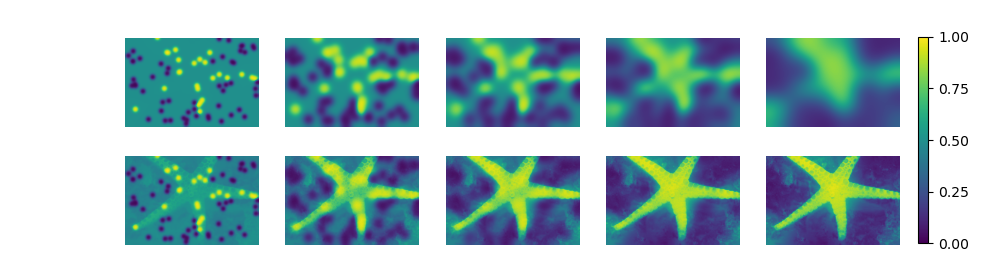

In [62]:
plot_starfish2()

In [68]:
def plot_starfish3():
    
    lgsrs = []
    lrncs = []

    graph = ProductGraph.lattice(im1.size[1], im1.size[0])
    fil = UnivariateFilterFunction.diffusion(100)

    for gamma in [1e-6, 1e-5, 5e-5, 1e-4, 1e-3]:

        X, Y, gt = get_data_uniform(im1, gt1, 5e-4, seed=0)

        lrnc = LRNC(X, Y, graph, fil, gamma=gamma, lam=1e4)
        lgsr = LGSR(Y, graph, fil, gamma=gamma)

        lgsrs.append(lgsr.solve())
        lrncs.append(lrnc.solve())


    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 2.8))


    for i in range(5):

        cb = axes[0, i].imshow(lgsrs[i], vmin=0, vmax=1)
        axes[1, i].imshow(lrncs[i], vmin=0, vmax=1)

    for ax in axes.ravel():
        ax.axis('off')

    ax = fig.add_axes([0.68, 0.1, 0.28, 0.8])
    ax.axis('off')
    plt.colorbar(cb, ax=ax,  ticks=[0, 0.25, 0.5, 0.75, 1], location='right', shrink=0.92)

    plt.savefig('starfish3.pdf')

    subprocess.run(['pdfcrop', 'starfish3.pdf', 'starfish3.pdf'])

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `starfish3.pdf'.


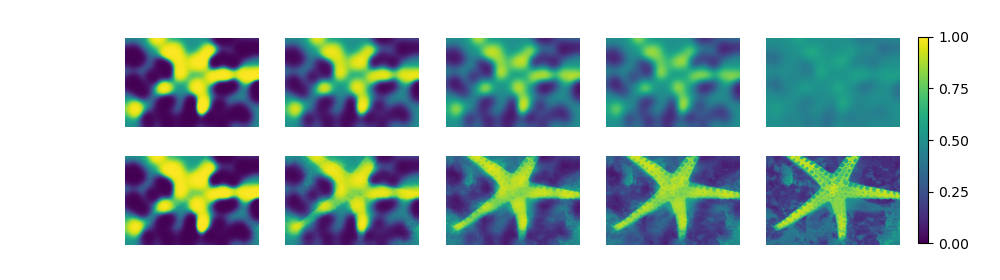

In [69]:
plot_starfish3()

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `hyperspectral.pdf'.


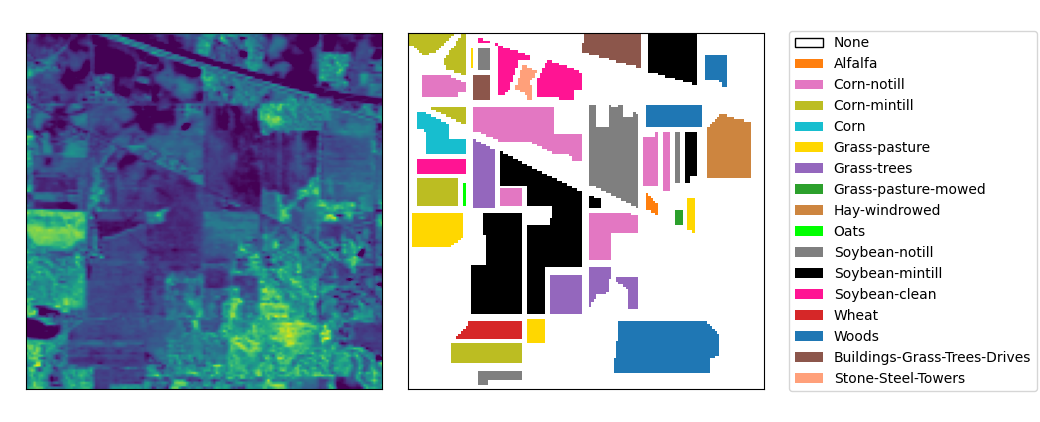

In [13]:
def plot_pines():

    data = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    gt = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
    
    names = ['None','Alfalfa','Corn-notill','Corn-mintill',	'Corn','Grass-pasture','Grass-trees','Grass-pasture-mowed','Hay-windrowed','Oats', 	
            'Soybean-notill','Soybean-mintill','Soybean-clean','Wheat','Woods','Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers']

    cols = ['white', 'tab:orange', 'tab:pink', 'tab:olive', 'tab:cyan', 'gold', 'tab:purple', 'tab:green', 'peru', 'lime',
            'tab:gray', 'black', 'deeppink', 'tab:red', 'tab:blue', 'tab:brown', 'lightsalmon', 'navy']

    fig, axes = plt.subplots(ncols=2, figsize=(10.4, 4.22))

    for i in range(17):
        axes[1].imshow(np.where(gt == i, gt, np.nan), cmap=mpl.colors.ListedColormap([cols[i]]))

    axes[0].imshow(data[:, :, 50], vmin=4.5e3)

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    legend_handles =[Patch(facecolor=col, edgecolor='k' if col == 'white' else None,  label=name) for col, name in zip(cols, names)]

    axes[1].legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.05, 0.5))

    plt.tight_layout()

    plt.subplots_adjust(wspace=0.01)

    plt.savefig('hyperspectral.pdf')

    subprocess.run(['pdfcrop', 'hyperspectral.pdf', 'hyperspectral.pdf'])

plot_pines()

In [9]:

def get_data_pines(s, seed):

    data = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    gt = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

    np.random.seed(seed)

    all_inds = np.indices(gt.shape).reshape(2, -1).T

    np.random.shuffle(all_inds)

    Y = gt.copy().astype(float)

    X = np.stack([data[:, :, 5 * i:5 * (i+1)].mean(axis=-1) for i in range(40)], axis=-1)

    X = (X - X.mean()) / X.std()

    S = np.zeros_like(Y)
    
    N = np.prod(Y.shape)
    N_ = int((1 - s) * N)
    Y[all_inds[:N_, 1], all_inds[:N_, 0]] = np.nan

    return X.astype(float), Y, gt


In [29]:
X, Y, gt = get_data_pines(0.2, seed=0)

graph = ProductGraph.lattice(*Y.shape)

fil = UnivariateFilterFunction.diffusion(20)

lrnc = MulticlassLRNC(X, Y, graph, fil, 1e-3, 1e2)
lgsr = MulticlassLGSR(Y, graph, fil, 5e-3)

pred_lnrc = lrnc.solve(classify=False)
# pred_lgsr = lgsr.solve(classify=False)

0.2918959476287444
0.3476458419063839
0.1659416118280017
0.06721164821502003
0.023995720388643248
0.0032853100323328834
6.583330697945854e-05


In [22]:
from sklearn.linear_model import Ridge

rid = Ridge(alpha=10)



In [25]:
X.reshape(-1, 40)

array([[ 0.975,  1.523,  1.352,  1.279,  1.127, ..., -0.888, -0.917, -0.961, -0.99 , -1.028],
       [ 0.942,  1.676,  1.591,  1.569,  1.432, ..., -0.875, -0.908, -0.956, -0.986, -1.021],
       [ 1.104,  1.716,  1.658,  1.649,  1.537, ..., -0.869, -0.9  , -0.951, -0.982, -1.023],
       [ 0.998,  1.687,  1.607,  1.593,  1.455, ..., -0.875, -0.906, -0.952, -0.981, -1.024],
       [ 0.957,  1.548,  1.412,  1.345,  1.197, ..., -0.885, -0.913, -0.958, -0.986, -1.023],
       ...,
       [ 0.706,  0.998,  0.684,  0.384,  0.074, ..., -1.019, -1.033, -1.04 , -1.047, -1.053],
       [ 0.727,  1.002,  0.681,  0.368,  0.07 , ..., -1.02 , -1.033, -1.041, -1.046, -1.055],
       [ 0.798,  0.981,  0.683,  0.258,  0.055, ..., -1.022, -1.035, -1.041, -1.046, -1.052],
       [ 0.802,  0.987,  0.546,  0.317,  0.044, ..., -1.023, -1.031, -1.042, -1.05 , -1.052],
       [ 0.795,  0.956,  0.668,  0.341,  0.053, ..., -1.02 , -1.03 , -1.044, -1.048, -1.054]])

In [26]:
Y

array([[nan, nan, nan, nan, nan, ...,  0., nan, nan, nan,  0.],
       [nan, nan, nan, nan, nan, ..., nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, ..., nan, nan,  0.,  0., nan],
       [nan, nan,  3., nan, nan, ..., nan, nan, nan,  0., nan],
       [nan, nan, nan, nan, nan, ...,  0., nan, nan, nan, nan],
       ...,
       [nan,  0., nan, nan, nan, ..., nan, nan, nan, nan, nan],
       [ 0., nan, nan, nan, nan, ..., nan, nan, nan,  0., nan],
       [nan, nan,  0., nan, nan, ...,  0., nan, nan,  0., nan],
       [nan,  0.,  0., nan, nan, ..., nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, ..., nan, nan, nan,  0., nan]])

In [10]:
def plot_pines():

    X, Y, gt = get_data_pines(0.2, seed=0)

    graph = ProductGraph.lattice(*Y.shape)

    fil = UnivariateFilterFunction.diffusion(20)

    lrnc = MulticlassLRNC(X, Y, graph, fil, 5e-3, 1e2)
    lgsr = MulticlassLGSR(Y, graph, fil, 5e-3)

    pred_lnrc = lrnc.solve(classify=True)
    pred_lgsr = lgsr.solve(classify=True)
    
    fig, axes = plt.subplots(ncols=3, figsize=(10, 4))

    names = ['None','Alfalfa','Corn-notill','Corn-mintill',	'Corn','Grass-pasture','Grass-trees','Grass-pasture-mowed','Hay-windrowed','Oats', 	
            'Soybean-notill','Soybean-mintill','Soybean-clean','Wheat','Woods','Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers']

    cols = ['white', 'tab:orange', 'tab:pink', 'tab:olive', 'tab:cyan', 'gold', 'tab:purple', 'tab:green', 'peru', 'lime',
            'tab:gray', 'black', 'deeppink', 'tab:red', 'tab:blue', 'tab:brown', 'lightsalmon', 'navy']


    for i in range(17):
        # axes[0].imshow(np.where(gt == i, gt, np.nan), cmap=mpl.colors.ListedColormap([cols[i]]), interpolation='nearest')
        axes[0].imshow(np.where(Y == i, gt, np.nan), cmap=mpl.colors.ListedColormap([cols[i]]), interpolation='nearest')
        axes[1].imshow(np.where(pred_lgsr == i, gt, np.nan), cmap=mpl.colors.ListedColormap([cols[i]]), interpolation='nearest')
        axes[2].imshow(np.where(pred_lnrc == i, gt, np.nan), cmap=mpl.colors.ListedColormap([cols[i]]), interpolation='nearest')

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()

    plt.savefig('pines.pdf')

    subprocess.run(['pdfcrop', 'pines.pdf', 'pines.pdf'])


0.0624181978323095
0.41834022511577224
0.211898762091273
0.052574557441257275
0.022231889152893074
0.003754562738208054
0.00013696833144057733
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `pines.pdf'.


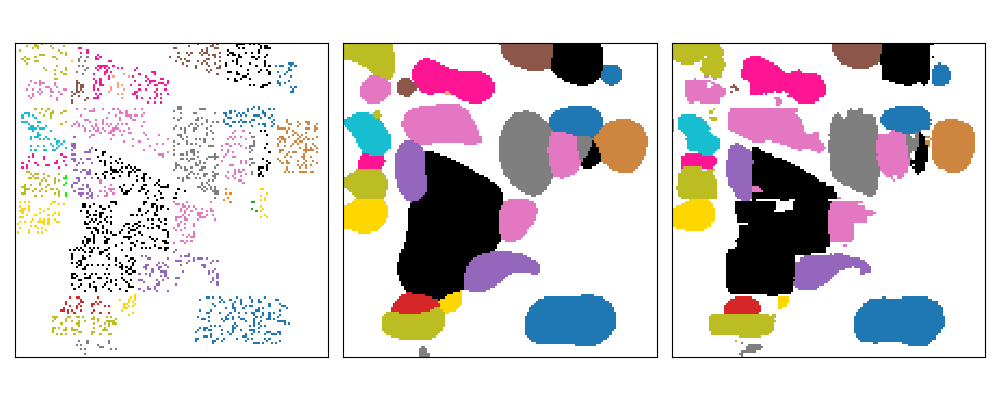

In [11]:
plot_pines()